# EPOCH Week4 D팀 Task (4기 박정민) (데싸노트의 실전에서 통하는 머신러닝)


# CH10. XGBoost : 커플 성사 여부 예측하기 (p.327 ~ p.363)

## XGBoost 소개

- 부스팅 알고리즘 : 트리를 순차적으로 만들면서 이전 트리에서 학습한 내용이 다음 트리를 만들 때 반영되도록 하는 알고리즘
- 부스팅 알고리즘을 활용하여 만든게 XGBoost이다.
- 장점 : 예측속도가 빠르고 예측력이 좋다, 변수 종류가 많고 데이터가 클수록 뛰어난 성능을 보인다.
- 단점 : 해석이 어렵다, 하이퍼파라미터 튜닝이 까다롭다.

## 10.2 라이브러리 및 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/dating.csv'
data = pd.read_csv(file_url)

In [ ]:
data.head()

,has_null,gender,age,age_o,race,race_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,...,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
0,0,female,21.0,27.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,35.0,20.0,...,7.0,6.0,5.0,0.14,3.0,2.0,7.0,6.0,0.0,0
1,0,female,21.0,22.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,60.0,0.0,...,8.0,5.0,6.0,0.54,3.0,2.0,7.0,5.0,1.0,0
2,1,female,21.0,22.0,Asian/PacificIslander/Asian-American,Asian/PacificIslander/Asian-American,2.0,4.0,19.0,18.0,...,8.0,5.0,7.0,0.16,3.0,2.0,7.0,NaN,1.0,1
3,0,female,21.0,23.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,30.0,5.0,...,7.0,6.0,8.0,0.61,3.0,2.0,7.0,6.0,0.0,1
4,0,female,21.0,24.0,Asian/PacificIslander/Asian-American,Latino/HispanicAmerican,2.0,4.0,30.0,10.0,...,7.0,6.0,6.0,0.21,3.0,2.0,6.0,6.0,0.0,1


In [ ]:
pd.options.display.max_columns = 40  # 컬럼이 40개가 출력되도록 설정

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   has_null                       8378 non-null   int64  
 1   gender                         8378 non-null   object 
 2   age                            8283 non-null   float64
 3   age_o                          8274 non-null   float64
 4   race                           8315 non-null   object 
 5   race_o                         8305 non-null   object 
 6   importance_same_race           8299 non-null   float64
 7   importance_same_religion       8299 non-null   float64
 8   pref_o_attractive              8289 non-null   float64
 9   pref_o_sincere                 8289 non-null   float64
 10  pref_o_intelligence            8289 non-null   float64
 11  pref_o_funny                   8280 non-null   float64
 12  pref_o_ambitious               8271 non-null   f

In [ ]:
round(data.describe(), 2)

,has_null,age,age_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sincere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
count,8378.00,8283.00,8274.00,8299.00,8299.00,8289.00,8289.00,8289.00,8280.00,8271.00,8249.00,8166.00,8091.00,8072.00,8018.00,7656.00,7302.00,8299.00,8299.00,8299.00,8289.00,8279.00,8257.00,8176.00,8101.00,8082.00,8028.00,7666.00,7311.00,8220.00,8277.00,1800.00,8138.00,8069.00,8003.00,8378.00
mean,0.87,26.36,26.36,3.78,3.65,22.50,17.40,20.27,17.46,10.69,11.85,6.19,7.18,7.37,6.40,6.78,5.47,22.51,17.40,20.27,17.46,10.68,11.85,6.19,7.18,7.37,6.40,6.78,5.47,0.20,5.53,5.57,6.13,5.21,0.05,0.16
std,0.33,3.57,3.56,2.85,2.81,12.57,7.04,6.78,6.09,6.13,6.36,1.95,1.74,1.55,1.95,1.79,2.16,12.59,7.05,6.78,6.09,6.12,6.36,1.95,1.74,1.55,1.95,1.79,2.16,0.30,1.73,4.76,1.84,2.13,0.28,0.37
min,0.00,18.00,18.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.83,1.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,24.00,24.00,1.00,1.00,15.00,15.00,17.39,15.00,5.00,9.52,5.00,6.00,6.00,5.00,6.00,4.00,15.00,15.00,17.39,15.00,5.00,9.52,5.00,6.00,6.00,5.00,6.00,4.00,-0.02,5.00,2.00,5.00,4.00,0.00,0.00
50%,1.00,26.00,26.00,3.00,3.00,20.00,18.37,20.00,18.00,10.00,10.64,6.00,7.00,7.00,7.00,7.00,6.00,20.00,18.18,20.00,18.00,10.00,10.64,6.00,7.00,7.00,7.00,7.00,6.00,0.21,6.00,4.00,6.00,5.00,0.00,0.00
75%,1.00,28.00,28.00,6.00,6.00,25.00,20.00,23.81,20.00,15.00,16.00,8.00,8.00,8.00,8.00,8.00,7.00,25.00,20.00,23.81,20.00,15.00,16.00,8.00,8.00,8.00,8.00,8.00,7.00,0.43,7.00,8.00,7.00,7.00,0.00,0.00
max,1.00,55.00,55.00,10.00,10.00,100.00,60.00,50.00,50.00,53.00,30.00,10.50,10.00,10.00,11.00,10.00,10.00,100.00,60.00,50.00,50.00,53.00,30.00,10.00,10.00,10.00,10.00,10.00,10.00,0.91,10.00,20.00,10.00,10.00,8.00,1.00


## 10.3 전처리 : 결측치 처리

In [ ]:
data.isna().mean()  # 결측치 비율 확인

,0
has_null,0.000000
gender,0.000000
age,0.011339
age_o,0.012413
race,0.007520
race_o,0.008713
importance_same_race,0.009429
importance_same_religion,0.009429
pref_o_attractive,0.010623
pref_o_sincere,0.010623


- XGBoost는 트리 기반이기에 결측치를 채우기는 까다롭지 않다.

In [ ]:
# 특정 변수만 dropna로 결측치 제거
data = data.dropna(subset = ['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
                             'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_important', 'sincere_important',
                             'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important'])

In [ ]:
data = data.fillna(-99)

## 10.4 전처리 : 피처 엔지니어링

In [ ]:
# 나이 차이에 대한 함수
def age_gap(x):
  if x['age'] == -99:
    return -99
  elif x['age_o'] == -99:
    return -99
  elif x['gender'] == 'female':
    return x['age_o'] - x['age']  # 여자가 연상이면 음수, 남자가 연상이면 양수
  else:
    return x['age'] - x['age_o']

In [ ]:
data['age_gap'] = data.apply(age_gap, axis = 1)

In [ ]:
data['age_gap_abs'] = abs(data['age_gap'])

In [ ]:
# 인종 관련 함수
def same_race(x):
  if x['race'] == -99:
    return -99
  elif x['race_o'] == -99:
    return -99
  elif x['race'] == x['race_o']:
    return 1
  else:
     return -1

In [ ]:
data['same_race'] = data.apply(same_race, axis = 1)

In [ ]:
# 동일 인종 중요도 함수
def same_race_point(x):
  if x['same_race'] == -99:
    return -99
  else:
    return x['same_race'] * x['importance_same_race']

In [ ]:
data['same_race_point'] = data.apply(same_race_point, axis = 1)

In [ ]:
# 평가/중요도 변수에 대한 함수
def rating(data, importance, score):
  if data[importance] == -99:
    return -99
  elif data[score] == -99:
    return -99
  else:
    return data[importance] * data[score]

In [ ]:
data.columns[8:14]

Index(['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
       'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests'],
      dtype='object')

In [ ]:
# 컬럼 리스트 업
partner_imp = data.columns[8:14]
partner_rate_me = data.columns[14:20]
my_imp = data.columns[20:26]
my_rate_partner = data.columns[26:32]

In [ ]:
# 상대방 관련 새 변수 이름 저장
new_label_partner = ['attractive_p', 'sincere_partner_p', 'intelligence_p', 'funny_p', 'ambition_p', 'shared_interests_p']

# 본인 관련 새 변수 이름 저장
new_label_me = ['attractive_m', 'sincere_partner_m', 'intelligence_m', 'funny_m', 'ambition_m', 'shared_interests_m']

In [ ]:
# rating 함수 적용
for i,j,k in zip(new_label_partner, partner_imp, partner_rate_me):
  data[i] = data.apply(lambda x: rating(x, j, k), axis = 1)

In [ ]:
# rating 함수 적용
for i,j,k in zip(new_label_me, my_imp, my_rate_partner):
  data[i] = data.apply(lambda x: rating(x, j, k), axis = 1)

In [ ]:
# 더미 변수 변환
data = pd.get_dummies(data, columns = ['gender', 'race', 'race_o'], drop_first=True)

## 10.5 모델링 및 평가

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('match', axis = 1), data['match'], test_size = 0.2, random_state = 100)

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(n_estimators = 500, max_depth = 5, random_state = 100)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
pred = model.predict(X_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_test, pred)

0.8640836408364083

In [ ]:
print(confusion_matrix(y_test, pred))

[[1289   76]
 [ 145  116]]


In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1365
           1       0.60      0.44      0.51       261

    accuracy                           0.86      1626
   macro avg       0.75      0.69      0.72      1626
weighted avg       0.85      0.86      0.86      1626



## 10.7 하이퍼파라미터 튜닝 : 그리드 서치

- 그리드 기법
> - 그리드서치는 모델이 아니다. 모델링을 하는데에 반영되는 기법이다.
> - 모든 경우의 수 중에서 가장 좋은 파라미터를 찾아준다(시간이 많이 걸림)

In [ ]:
max_depth = [3, 5, 10]
laeraning_rate = [0.01, 0.05, 0.1]

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'learning_rate' : [0.01, 0.1, 0.3],
              'max_depth' : [5, 7, 10],
              'subsample' : [0.5, 0.7, 1],
              'n_estimators' : [300, 500, 1000]}

In [ ]:
model = xgb.XGBClassifier()
gs_model = GridSearchCV(model, parameters, n_jobs = -1, scoring = 'f1', cv = 5)
gs_model.fit(X_train, y_train)
gs_model.best_params_

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1}

In [ ]:
pred = gs_model.predict(X_test)
accuracy_score(y_test, pred)

0.8659286592865929

## 10.8 중요 변수 확인

In [ ]:
model = xgb.XGBClassifier(learning_rate = 0.3, max_depth = 5, n_estimators = 1000, subsample = 0.5, random_state = 100)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
model.feature_importances_

array([0.02782578, 0.01232159, 0.01116486, 0.01063812, 0.01468509,
       0.01528096, 0.01357219, 0.01455206, 0.00982193, 0.01188237,
       0.01461569, 0.04682781, 0.01465946, 0.01151065, 0.03083666,
       0.0153234 , 0.01940022, 0.0168594 , 0.01216484, 0.01672762,
       0.01280323, 0.01128936, 0.01167591, 0.02823533, 0.01262605,
       0.01171707, 0.0278949 , 0.01277483, 0.01765355, 0.01068022,
       0.01125237, 0.02258227, 0.06751092, 0.02003114, 0.03643113,
       0.01299904, 0.01252737, 0.00694877, 0.01160695, 0.01413235,
       0.01089615, 0.01252362, 0.01289575, 0.01087758, 0.01100085,
       0.01121726, 0.0122557 , 0.01313891, 0.01227399, 0.01179242,
       0.0128882 , 0.01540276, 0.02415291, 0.01162643, 0.0175925 ,
       0.02408599, 0.03323882, 0.01345744, 0.00493584, 0.00970344],
      dtype=float32)

In [ ]:
feature_imp = pd.DataFrame({'features' : X_train.columns, 'values' : model.feature_importances_})
feature_imp.head()

,features,values
0,has_null,0.027826
1,age,0.012322
2,age_o,0.011165
3,importance_same_race,0.010638
4,importance_same_religion,0.014685


<Axes: xlabel='values', ylabel='features'>

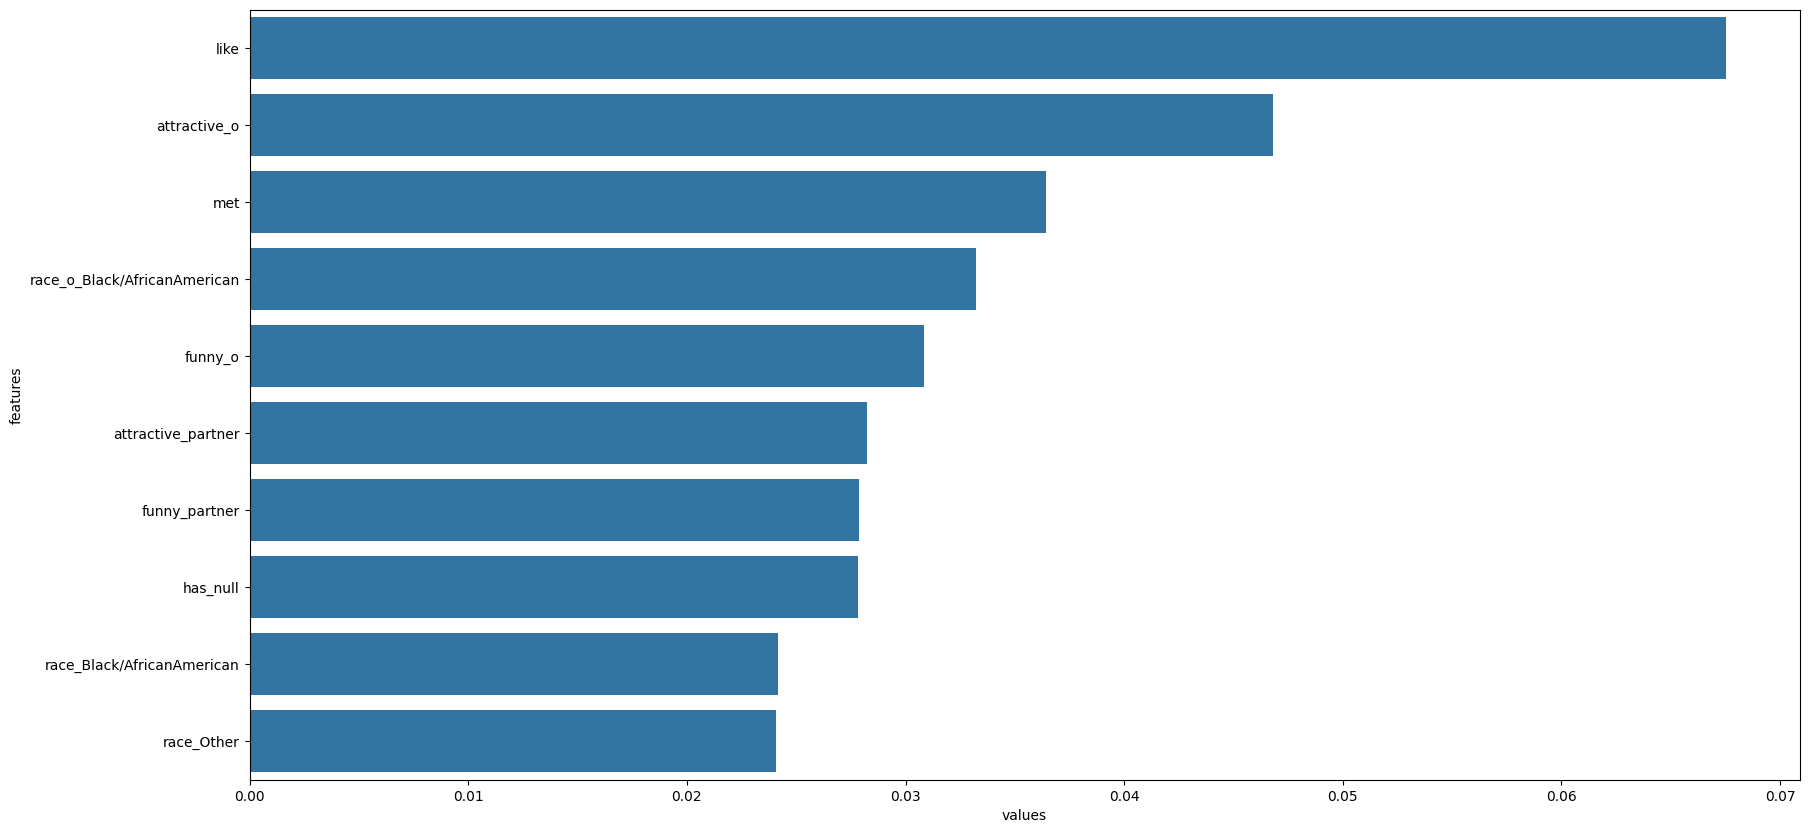

In [ ]:
plt.figure(figsize = (20, 10))
sns.barplot(x = 'values', y = 'features', data = feature_imp.sort_values(by = 'values', ascending = False).head(10))

# CH11. LightGBM : 이상거래 예측하기 (p.365 ~ p.405)

## LightGBM 소개

- 리프 중심 트리 분할 방식
- 장점
> - XGBoost보다 빠르고 높은 정확도
> - 변수 중요도 확인가능
> - 변수 종류가 많고 데이터가 클수록 좋은 성능
- 단점
> - 해석이 어려움
> - 하이퍼파라미터 튜닝이 까다로움

## 11.2 라이브러리 및 데이터 불러오기, 데이터 확인하기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/fraud.csv'
data = pd.read_csv(file_url)
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int

In [ ]:
data.info(show_counts=True)   # Non-Null 값이 보이도록

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   cc_num                 1852394 non-null  int64  
 2   merchant               1852394 non-null  object 
 3   category               1852394 non-null  object 
 4   amt                    1852394 non-null  float64
 5   first                  1852394 non-null  object 
 6   last                   1852394 non-null  object 
 7   gender                 1852394 non-null  object 
 8   street                 1852394 non-null  object 
 9   city                   1852394 non-null  object 
 10  state                  1852394 non-null  object 
 11  zip                    1852394 non-null  int64  
 12  lat                    1852394 non-null  float64
 13  long                   1852394 non-null  float64
 14  city_pop          

In [ ]:
round(data.describe(), 2)

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1.852394e+06,1852394.00,1852394.00,1852394.00
mean,4.173860e+17,70.06,48813.26,38.54,-90.23,88643.67,1.358674e+09,38.54,-90.23,0.01
std,1.309115e+18,159.25,26881.85,5.07,13.75,301487.62,1.819508e+07,5.11,13.76,0.07
min,6.041621e+10,1.00,1257.00,20.03,-165.67,23.00,1.325376e+09,19.03,-166.67,0.00
25%,1.800429e+14,9.64,26237.00,34.67,-96.80,741.00,1.343017e+09,34.74,-96.90,0.00
50%,3.521417e+15,47.45,48174.00,39.35,-87.48,2443.00,1.357089e+09,39.37,-87.44,0.00
75%,4.642255e+15,83.10,72042.00,41.94,-80.16,20328.00,1.374581e+09,41.96,-80.25,0.00
max,4.992346e+18,28948.90,99921.00,66.69,-67.95,2906700.00,1.388534e+09,67.51,-66.95,1.00


## 11.3 전처리 : 데이터 클리닝

- 이상거래를 탐지하는데 필요없는 피쳐는 뭐가 있을까??
> - 거주지 변수 : street, city, state, zip, lat, long
>> - 이 중 위도와 경도만 남기고 제거
> - 거래번호, 거래시간, 직업, 거래 상점 또한 제거

In [ ]:
data.drop(['first', 'last', 'street', 'city', 'state', 'zip', 'trans_num', 'unix_time', 'job', 'merchant'], axis = 1, inplace=True)
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   category               object        
 3   amt                    float64       
 4   gender                 object        
 5   lat                    float64       
 6   long                   float64       
 7   city_pop               int64         
 8   dob                    object        
 9   merch_lat              float64       
 10  merch_long             float64       
 11  is_fraud               int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(3)
memory usage: 169.6+ MB


In [ ]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1852394 non-null  datetime64[ns]
 1   cc_num                 1852394 non-null  int64         
 2   category               1852394 non-null  object        
 3   amt                    1852394 non-null  float64       
 4   gender                 1852394 non-null  object        
 5   lat                    1852394 non-null  float64       
 6   long                   1852394 non-null  float64       
 7   city_pop               1852394 non-null  int64         
 8   dob                    1852394 non-null  object        
 9   merch_lat              1852394 non-null  float64       
 10  merch_long             1852394 non-null  float64       
 11  is_fraud               1852394 non-null  int64         
dtypes: datetime64[ns](1), float6

## 11.4 전처리 : 피처 엔지니어링

- 이상치 탐지 : 고객의 기존 거래 패턴에서 벗어나는 경우를 감지하는 것


### 11.4.1 결제 금액
- 적은 금액으로 결제하던 고객이 갑자기 큰 금액을 소비하는 경우
- 패턴을 파악하기 위해 **Z 점수** 를 사용한다.
- $Z 점수 = \frac {x(특정값) - \mu(평균)} {\sigma(표준편차)}$

In [ ]:
data['cc_num'].value_counts()

,count
cc_num,
30270432095985,4392
6538441737335434,4392
4642255475285942,4386
6538891242532018,4386
4364010865167176,4386
...,...
501894933032,7
4975457191020,7
6577777028615915,7


In [ ]:
data['amt'].value_counts()

,count
amt,
1.14,779
1.10,745
1.04,744
1.08,741
1.25,737
...,...
440.77,1
262.03,1
586.94,1


In [ ]:
amt_info = data.groupby('cc_num')['amt'].agg(['mean', 'std']).reset_index()
amt_info

,cc_num,mean,std
0,60416207185,59.257796,142.869746
1,60422928733,65.483159,92.042844
2,60423098130,96.376084,1000.693872
3,60427851591,107.487550,131.014534
4,60487002085,64.096925,153.207660
...,...,...,...
994,4958589671582726883,67.205600,137.504101
995,4973530368125489546,75.789148,258.847061
996,4980323467523543940,70.709484,119.903167
997,4989847570577635369,93.008939,128.396760


In [ ]:
amt_info.head()

,cc_num,mean,std
0,60416207185,59.257796,142.869746
1,60422928733,65.483159,92.042844
2,60423098130,96.376084,1000.693872
3,60427851591,107.487550,131.014534
4,60487002085,64.096925,153.207660


In [ ]:
data = data.merge(amt_info, on = 'cc_num', how = 'left')  # 데이터 merge

In [ ]:
data['amt_z_score'] = (data['amt'] - data['mean']) / data['std']
data['amt_z_score']

,amt_z_score
0,-0.662108
1,0.321302
2,1.287064
3,-0.125287
4,-0.565941
...,...
1852389,-0.167639
1852390,0.364619
1852391,-0.015209
1852392,-0.592099


In [ ]:
data[['amt', 'mean', 'std', 'amt_z_score']].head()

,amt,mean,std,amt_z_score
0,4.97,89.408743,127.530101,-0.662108
1,107.23,56.078113,159.201852,0.321302
2,220.11,69.924272,116.688602,1.287064
3,45.00,80.090040,280.077880,-0.125287
4,41.96,95.341146,94.322842,-0.565941


In [ ]:
# 이제 mean과 std는 필요없으니 제거
data.drop(['mean', 'std'], axis = 1, inplace = True)
data.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z_score
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0,-0.662108
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,42.1808,-112.2620,4154,1962-01-19,43.150704,-112.154481,0,1.287064
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,46.2306,-112.1138,1939,1967-01-12,47.034331,-112.561071,0,-0.125287
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,38.4207,-79.4629,99,1986-03-28,38.674999,-78.632459,0,-0.565941


### 11.4.2 범주

In [ ]:
# 범주형 변수
cat_info = data.groupby(['cc_num', 'category'])['amt'].agg(['mean', 'std']).reset_index()
cat_info

,cc_num,category,mean,std
0,60416207185,entertainment,51.838855,65.485714
1,60416207185,food_dining,26.737097,46.382603
2,60416207185,gas_transport,59.779429,15.758267
3,60416207185,grocery_net,52.152973,17.694871
4,60416207185,grocery_pos,101.557761,21.894156
...,...,...,...,...
13166,4992346398065154184,misc_pos,60.003043,167.226191
13167,4992346398065154184,personal_care,48.777227,49.523818
13168,4992346398065154184,shopping_net,86.280136,217.047242
13169,4992346398065154184,shopping_pos,64.213333,169.239073


In [ ]:
data = data.merge(cat_info, on = ['cc_num', 'category'], how = 'left') # 데이터 merge

In [ ]:
# 위와 동일하게 Z-score 구하고 mean, std 제거
data['cat_z_score'] = (data['amt'] - data['mean']) / data['std']
data.drop(['mean', 'std'], axis = 1, inplace = True)

In [ ]:
data.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z_score,cat_z_score
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0,-0.662108,-0.688297
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302,0.317631
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,42.1808,-112.2620,4154,1962-01-19,43.150704,-112.154481,0,1.287064,2.872509
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,46.2306,-112.1138,1939,1967-01-12,47.034331,-112.561071,0,-0.125287,-1.050197
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,38.4207,-79.4629,99,1986-03-28,38.674999,-78.632459,0,-0.565941,1.312866


### 11.4.3 거리

In [ ]:
import geopy.distance
# geopy.distance.distance((위도1, 경도1), (위도2, 경도2))

In [ ]:
# merch_coord : 상점에 대한 위치를 위도와 경도 한 변수로 합침
# cust_coord : 고객에 대한 위치를 위도와 경도 한 변수로 합침
data['merch_coord'] = pd.Series(zip(data['merch_lat'], data['merch_long']))
data['cust_coord'] = pd.Series(zip(data['lat'], data['long']))

- distance 함수의 경우 시리즈 형태가 아니기에 한 건씩 데이터를 처리함 => apply를 이용해서 함수 적용을 해줘야한다.

In [ ]:
# 거리 계산
data['distance'] = data.apply(lambda x : geopy.distance.distance(x['merch_coord'], x['cust_coord']).km, axis = 1)
data.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z_score,cat_z_score,merch_coord,cust_coord,distance
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0,-0.662108,-0.688297,"(36.011293, -82.048315)","(36.0788, -81.1781)",78.773821
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302,0.317631,"(49.159047, -118.186462)","(48.8878, -118.2105)",30.216618
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,42.1808,-112.2620,4154,1962-01-19,43.150704,-112.154481,0,1.287064,2.872509,"(43.150704, -112.154481)","(42.1808, -112.262)",108.102912
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,46.2306,-112.1138,1939,1967-01-12,47.034331,-112.561071,0,-0.125287,-1.050197,"(47.034331, -112.561071)","(46.2306, -112.1138)",95.685115
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,38.4207,-79.4629,99,1986-03-28,38.674999,-78.632459,0,-0.565941,1.312866,"(38.674999, -78.632459)","(38.4207, -79.4629)",77.702395


In [ ]:
# cc_num 그룹 별 거리 정보
distance_info = data.groupby('cc_num')['distance'].agg(['mean', 'std']).reset_index()
data = data.merge(distance_info, on = 'cc_num', how = 'left')   # 데이터 merge
data['distance_z_score'] = (data['distance'] - data['mean']) / data['std']  # z-score 계산하기
data.drop(['mean', 'std'], axis = 1, inplace = True)
data.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z_score,cat_z_score,merch_coord,cust_coord,distance,distance_z_score
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0,-0.662108,-0.688297,"(36.011293, -82.048315)","(36.0788, -81.1781)",78.773821,0.030974
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302,0.317631,"(49.159047, -118.186462)","(48.8878, -118.2105)",30.216618,-1.475224
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,42.1808,-112.2620,4154,1962-01-19,43.150704,-112.154481,0,1.287064,2.872509,"(43.150704, -112.154481)","(42.1808, -112.262)",108.102912,1.160572
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,46.2306,-112.1138,1939,1967-01-12,47.034331,-112.561071,0,-0.125287,-1.050197,"(47.034331, -112.561071)","(46.2306, -112.1138)",95.685115,0.818063
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,38.4207,-79.4629,99,1986-03-28,38.674999,-78.632459,0,-0.565941,1.312866,"(38.674999, -78.632459)","(38.4207, -79.4629)",77.702395,0.064037


### 11.4.4 나이 구하기

In [ ]:
data['age'] = 2021 - pd.to_datetime(data['dob']).dt.year

In [ ]:
# 예측에 필요없는 변수 제거
data.drop(['cc_num', 'lat', 'long', 'merch_lat', 'merch_long', 'dob', 'merch_coord', 'cust_coord'], axis = 1, inplace = True)
data.head()

,trans_date_trans_time,category,amt,gender,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_score,age
0,2019-01-01 00:00:18,misc_net,4.97,F,3495,0,-0.662108,-0.688297,78.773821,0.030974,33
1,2019-01-01 00:00:44,grocery_pos,107.23,F,149,0,0.321302,0.317631,30.216618,-1.475224,43
2,2019-01-01 00:00:51,entertainment,220.11,M,4154,0,1.287064,2.872509,108.102912,1.160572,59
3,2019-01-01 00:01:16,gas_transport,45.00,M,1939,0,-0.125287,-1.050197,95.685115,0.818063,54
4,2019-01-01 00:03:06,misc_pos,41.96,M,99,0,-0.565941,1.312866,77.702395,0.064037,35


### 11,4,5 새 변수 만들기

In [ ]:
data = pd.get_dummies(data, columns = ['category', 'gender'], drop_first = True)
data.head()

,trans_date_trans_time,amt,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_score,age,category_food_dining,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2019-01-01 00:00:18,4.97,3495,0,-0.662108,-0.688297,78.773821,0.030974,33,False,...,False,False,False,True,False,False,False,False,False,False
1,2019-01-01 00:00:44,107.23,149,0,0.321302,0.317631,30.216618,-1.475224,43,False,...,False,False,False,False,False,False,False,False,False,False
2,2019-01-01 00:00:51,220.11,4154,0,1.287064,2.872509,108.102912,1.160572,59,False,...,False,False,False,False,False,False,False,False,False,True
3,2019-01-01 00:01:16,45.00,1939,0,-0.125287,-1.050197,95.685115,0.818063,54,False,...,False,False,False,False,False,False,False,False,False,True
4,2019-01-01 00:03:06,41.96,99,0,-0.565941,1.312866,77.702395,0.064037,35,False,...,False,False,False,False,True,False,False,False,False,True


In [ ]:
data.set_index('trans_date_trans_time', inplace = True)
data.head()

,amt,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_score,age,category_food_dining,category_gas_transport,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
trans_date_trans_time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:18,4.97,3495,0,-0.662108,-0.688297,78.773821,0.030974,33,False,False,...,False,False,False,True,False,False,False,False,False,False
2019-01-01 00:00:44,107.23,149,0,0.321302,0.317631,30.216618,-1.475224,43,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-01-01 00:00:51,220.11,4154,0,1.287064,2.872509,108.102912,1.160572,59,False,False,...,False,False,False,False,False,False,False,False,False,True
2019-01-01 00:01:16,45.00,1939,0,-0.125287,-1.050197,95.685115,0.818063,54,False,True,...,False,False,False,False,False,False,False,False,False,True
2019-01-01 00:03:06,41.96,99,0,-0.565941,1.312866,77.702395,0.064037,35,False,False,...,False,False,False,False,True,False,False,False,False,True


## 11.5 모델링 및 평가하기

In [ ]:
# 훈련셋과 테스트셋으로 나누기 (시계열 데이터이기에 무작위로 split하면 안됨)
train = data[data.index < '2020-07-01']
test = data[data.index >= '2020-07-01']

In [ ]:
len(test) / len(data)

0.2837738623640543

In [ ]:
X_train = train.drop('is_fraud', axis = 1)
X_test = test.drop('is_fraud', axis = 1)
y_train = train['is_fraud']
y_test = test['is_fraud']

In [ ]:
import lightgbm as lgb

In [ ]:
# LightGBM 모델링
model_1 = lgb.LGBMClassifier(random_state = 100)
model_1.fit(X_train, y_train)
pred_1 = model_1.predict(X_test)

[LightGBM] [Info] Number of positive: 7639, number of negative: 1319094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 1326733, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005758 -> initscore=-5.151434
[LightGBM] [Info] Start training from score -5.151434


In [ ]:
# accuracy, confusion matrix, ROC, AUC 등 확인하기
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
print('정확도 :', accuracy_score(y_test, pred_1))

정확도 : 0.9970760623291437


In [ ]:
print(confusion_matrix(y_test, pred_1))

[[522933    716]
 [   821   1191]]


In [ ]:
print(classification_report(y_test, pred_1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.62      0.59      0.61      2012

    accuracy                           1.00    525661
   macro avg       0.81      0.80      0.80    525661
weighted avg       1.00      1.00      1.00    525661



- 정밀도 : 0.58
- 재현율 : 0.62
- f1-score : 0.60

In [ ]:
proba_1 = model_1.predict_proba(X_test)

In [ ]:
proba_1

array([[9.99968780e-01, 3.12200159e-05],
       [9.99973950e-01, 2.60503888e-05],
       [9.99960796e-01, 3.92036962e-05],
       ...,
       [9.99964825e-01, 3.51746051e-05],
       [9.99844073e-01, 1.55926950e-04],
       [9.99945924e-01, 5.40758390e-05]])

In [ ]:
proba_1[:, 1]

array([3.12200159e-05, 2.60503888e-05, 3.92036962e-05, ...,
       3.51746051e-05, 1.55926950e-04, 5.40758390e-05])

In [ ]:
proba_1 = proba_1[:, 1]
proba_1

array([3.12200159e-05, 2.60503888e-05, 3.92036962e-05, ...,
       3.51746051e-05, 1.55926950e-04, 5.40758390e-05])

In [ ]:
proba_int1 = (proba_1 > 0.2).astype('int')  # 0.2를 기준으로 분류
proba_int2 = (proba_1 > 0.8).astype('int')  # 0,8을 기준으로 분류

In [ ]:
print(confusion_matrix(y_test, proba_int1))  # 0.2 기준

[[522105   1544]
 [   598   1414]]


In [ ]:
print(classification_report(y_test, proba_int1))  # 0,2 기준

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.48      0.70      0.57      2012

    accuracy                           1.00    525661
   macro avg       0.74      0.85      0.78    525661
weighted avg       1.00      1.00      1.00    525661



In [ ]:
print(confusion_matrix(y_test, proba_int2))  # 0.8 기준

[[523183    466]
 [   958   1054]]


In [ ]:
print(classification_report(y_test, proba_int2)) # 0.8 기준

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.69      0.52      0.60      2012

    accuracy                           1.00    525661
   macro avg       0.85      0.76      0.80    525661
weighted avg       1.00      1.00      1.00    525661



In [ ]:
roc_auc_score(y_test, proba_1)

np.float64(0.9366009328741358)

## 11.6 하이퍼파라미터 튜닝 : 랜덤 그리드 서치

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params = {'n_estimators' : [100, 500, 1000],
          'learning_rate' : [0.01, 0.05, 0.1, 0.3],
          'lambda_l1' : [0, 10, 20, 30, 50],
          'lambda_l2' : [0, 10, 20, 30, 50],
          'max_depth' : [5, 10, 15, 20],
          'subsample' : [0.6, 0.8, 1]}

In [ ]:
model_2 = lgb.LGBMClassifier(random_state = 100)
rs = RandomizedSearchCV(model_2, param_distributions = params, n_iter = 30, scoring = 'roc_auc', random_state = 100, n_jobs = -1)

In [ ]:
rs.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Number of positive: 7639, number of negative: 1319094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 1326733, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005758 -> initscore=-5.151434
[LightGBM] [Info] Start training from score -5.151434


RandomizedSearchCV(estimator=LGBMClassifier(random_state=100), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'lambda_l1': [0, 10, 20, 30, 50],
                                        'lambda_l2': [0, 10, 20, 30, 50],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.6, 0.8, 1]},
                   random_state=100, scoring='roc_auc')

In [ ]:
rs.best_params_

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.05,
 'lambda_l2': 20,
 'lambda_l1': 0}

In [ ]:
rs_proba = rs.predict_proba(X_test)
roc_auc_score(y_test, rs_proba[:,1])

[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0


np.float64(0.9953122884656392)

In [ ]:
rs_proba_int = (rs_proba[:, 1] > 0.2).astype('int')
print(confusion_matrix(y_test, rs_proba_int))

[[522519   1130]
 [   504   1508]]


In [ ]:
print(classification_report(y_test, rs_proba_int))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.57      0.75      0.65      2012

    accuracy                           1.00    525661
   macro avg       0.79      0.87      0.82    525661
weighted avg       1.00      1.00      1.00    525661



## 11.7 LightGBM의 train() 함수 사용하기

In [ ]:
train = data[data.index < '2020-01-01']
val = data[(data.index >= '2020-01-01') & (data.index < '2020-07-01')]
test = data[data.index >= '2020-07-01']

In [ ]:
X_train = train.drop('is_fraud', axis = 1)
X_val = val.drop('is_fraud', axis = 1)
X_test = test.drop('is_fraud', axis = 1)
y_train = train['is_fraud']
y_val = val['is_fraud']
y_test = test['is_fraud']

In [ ]:
d_train = lgb.Dataset(X_train, label = y_train)
d_val = lgb.Dataset(X_val, label = y_val)

In [ ]:
params_set = rs.best_params_
params_set['metrics'] = 'auc'

In [ ]:
params_set

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.05,
 'lambda_l2': 20,
 'lambda_l1': 0,
 'metrics': 'auc'}

In [ ]:
model_3 = lgb.train(params_set, d_train, valid_sets = [d_val],
                    callbacks=[lgb.early_stopping(100, verbose=100)])

[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=15) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32768) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=15) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32768) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 924850, number of used features: 21
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=15) without explicitly sett

In [ ]:
pred_3 = model_3.predict(X_test)

In [ ]:
roc_auc_score(y_test, pred_3)

np.float64(0.991352108964131)

<Axes: xlabel='importance', ylabel='feature_name'>

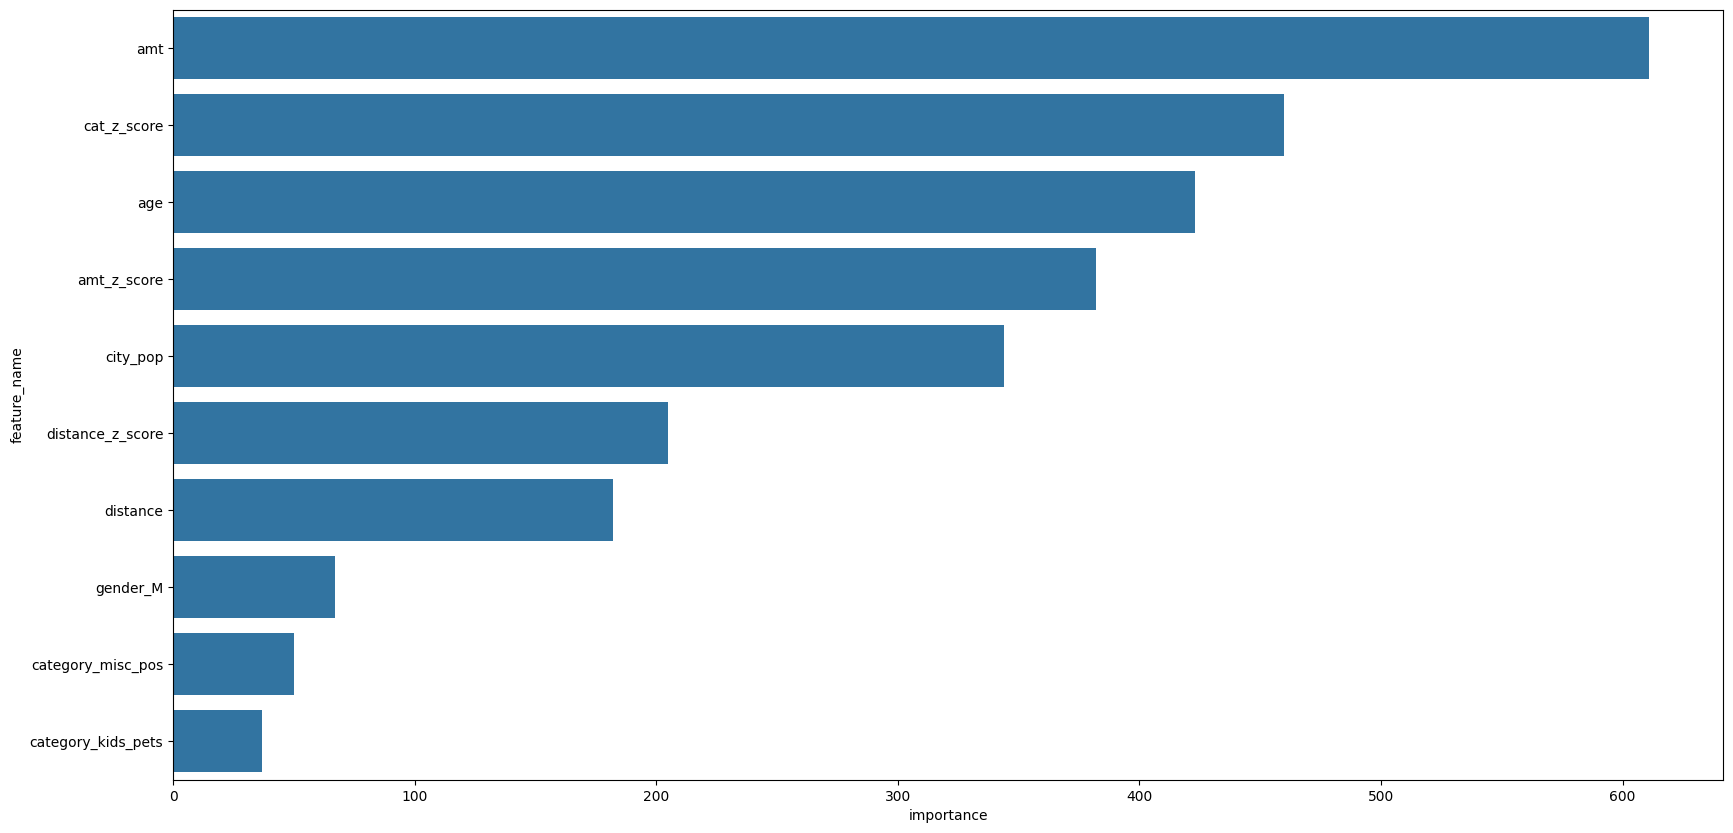

In [ ]:
feature_imp = pd.DataFrame({'feature_name' : X_train.columns,
                            'importance' : model_1.feature_importances_}).sort_values('importance', ascending = False)
plt.figure(figsize = (20, 10))
sns.barplot(x = 'importance', y = 'feature_name', data = feature_imp.head(10))

<Axes: xlabel='importance', ylabel='feature_name'>

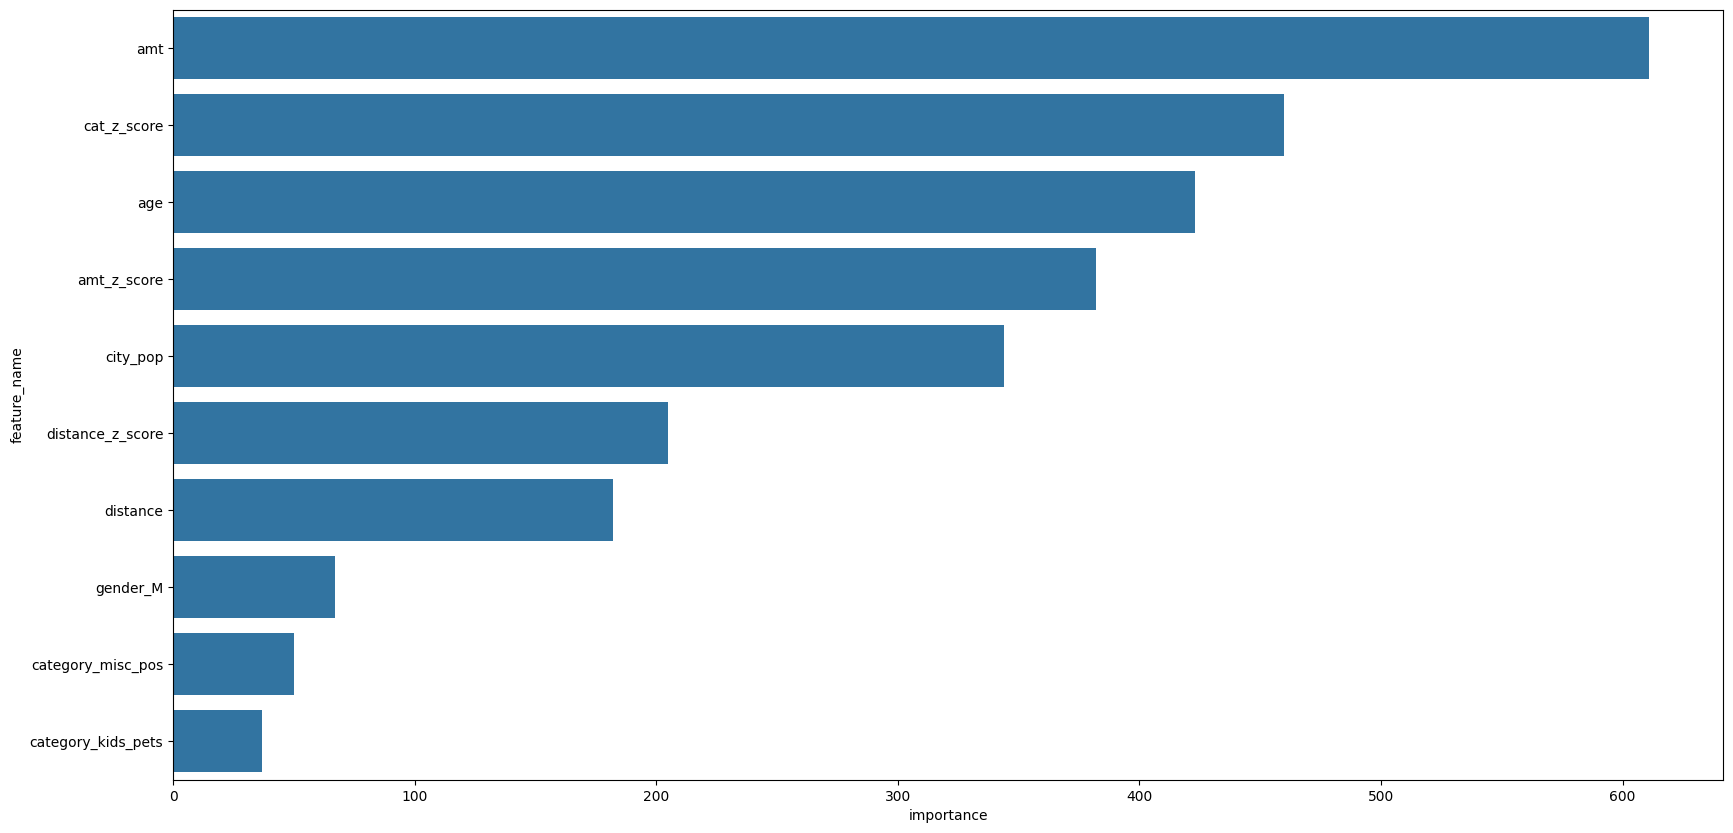

In [ ]:
feature_imp_3 = pd.DataFrame(sorted(zip(model_3.feature_importance(), X_train.columns)), columns = ['Value', 'Feature'])
plt.figure(figsize = (20,10))
sns.barplot(x="importance", y='feature_name', data=feature_imp.head(10))

## 궁금한점

- 10. XGBoost : 부스팅을 통해서 이전 에러를 기반으로 다음 트리를 만들어가는데, 이는 모델의 정확성이 향상되기에 편향이 줄어들지만, 분산이 많이 증가할 것 같은데, 실제로 이러한 편향-분산 trade off가 발생하나?

- 11. LightGBM : LightGBM이 XGBoost보다 5~10배 정도 속도 차이가 나는 걸로 알고 있다. 이번 fit에서 1시간 44분정도 걸렸는데, 만약 XGBoost를 사용한다면 실제로 10시간 정도 걸릴까? 아니면 GPU를 사용할 때에 있어서 XGBoost가 더 빨리 학습할까?